In [41]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms, datasets
from torch.utils.data import DataLoader
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
from torchvision.transforms import v2
import torch.optim as optim




In [42]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [43]:
BATCH_SIZE = 128
IMAGE_SIZE = 28

In [44]:
Transforms = v2.Compose([
    v2.ToImage(), 
    v2.ToDtype(torch.float32, scale=True),
    v2.Normalize((0.5,), (0.5,))
])
train_dataset = datasets.MNIST(root="C:/Users/Arun/pytorch/datasets", train=True, download=True, transform=Transforms)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True)

In [45]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class VectorQuantizer(nn.Module):
    def __init__(self, num_embeddings, embedding_dim, commitment_cost):
        super(VectorQuantizer, self).__init__()
        self.embedding_dim = embedding_dim
        self.num_embeddings = num_embeddings
        self.commitment_cost = commitment_cost
        
        self.embeddings = nn.Embedding(num_embeddings, embedding_dim)
        self.embeddings.weight.data.normal_(mean=0.0, std=0.1)

    def flatten_input(self, inputs):
        # Flatten the input tensor while maintaining the batch size and embedding dimension
        inputs = inputs.permute(0, 2, 3, 1).contiguous()  # shape: (B, H, W, C)
        input_shape = inputs.shape
        flat_input = inputs.view(-1, self.embedding_dim)  # shape: (B * H * W, C)
        return inputs, flat_input, input_shape

    def compute_distances(self, flat_input):
        # Compute squared L2 distances between the input and embeddings efficiently
        emb_weights = self.embeddings.weight  # shape: (num_embeddings, embedding_dim)
        distances = (
            torch.sum(flat_input**2, dim=1, keepdim=True)  # shape: (B * H * W, 1)
            + torch.sum(emb_weights**2, dim=1)  # shape: (num_embeddings,)
            - 2 * torch.matmul(flat_input, emb_weights.t())  # shape: (B * H * W, num_embeddings)
        )
        return distances

    def get_encoding_indices(self, distances):
        # Get the indices of the nearest embeddings
        encoding_indices = torch.argmin(distances, dim=1).unsqueeze(1)  # shape: (B * H * W, 1)
        return encoding_indices

    def quantize(self, encoding_indices, input_shape):
        # Generate one-hot encodings and compute quantized vectors
        encodings = torch.zeros(encoding_indices.size(0), self.num_embeddings, device=encoding_indices.device)
        encodings.scatter_(1, encoding_indices, 1)
        
        quantized = torch.matmul(encodings, self.embeddings.weight)  # shape: (B * H * W, embedding_dim)
        quantized = quantized.view(input_shape)  # Reshape to (B, H, W, embedding_dim)
        return quantized

    def compute_loss(self, quantized, inputs):
        # Compute the VQ-VAE loss efficiently
        e_latent_loss = F.mse_loss(quantized.detach(), inputs)
        q_latent_loss = F.mse_loss(quantized, inputs.detach())
        loss = q_latent_loss + self.commitment_cost * e_latent_loss
        return loss, self.commitment_cost * e_latent_loss, q_latent_loss

    def forward(self, inputs):
        # Process the input through the VQ-VAE pipeline
        inputs, flat_input, input_shape = self.flatten_input(inputs)
        distances = self.compute_distances(flat_input)
        encoding_indices = self.get_encoding_indices(distances)
        quantized = self.quantize(encoding_indices, input_shape)
        
        # Compute the loss and add gradients to the encoder
        loss, e_latent_loss, q_latent_loss = self.compute_loss(quantized, inputs)
        quantized = inputs + (quantized - inputs).detach()  # Gradient passthrough
        
        # Re-permute the quantized output back to (B, C, H, W)
        return quantized.permute(0, 3, 1, 2).contiguous(), loss, e_latent_loss, q_latent_loss



# class Encoder(nn.Module):
#     def __init__(self, latent_dim=2):
#         super(Encoder, self).__init__()
#         self.conv1 = nn.Conv2d(1, 16, kernel_size=4, stride=2, padding=1) 
#         self.conv2 = nn.Conv2d(16, 4, kernel_size=4, stride=2, padding=1)
#         self.outconv = nn.Conv2d(4, latent_dim, kernel_size=1)
        
#         self.bn1 = nn.BatchNorm2d(16)
#         self.bn2 = nn.BatchNorm2d(4)
        
#         self.relu = nn.ReLU()

#     def forward(self, x):
#         x = self.relu(self.bn1(self.conv1(x))) # 16 x 14 x 14
#         x = self.relu(self.bn2(self.conv2(x))) # 4 x 7 x 7
#         # x = self.relu(self.conv1(x)) # 16 x 14 x 14
#         # x = self.relu(self.conv2(x)) # 4 x 7 x 7
#         x = self.outconv(x)            # 2 x 7 x 7
#         return x


# class Decoder(nn.Module):
#     def __init__(self, latent_dim=2):
#         super(Decoder, self).__init__()
#         self.inconv = nn.ConvTranspose2d(latent_dim, 4, kernel_size=1)
#         self.deconv1 = nn.ConvTranspose2d(4, 16, kernel_size=4, stride=2, padding=1)
#         self.deconv2 = nn.ConvTranspose2d(16, 1, kernel_size=4, stride=2, padding=1)

#         # self.bn1 = nn.BatchNorm2d(4)
#         self.bn2 = nn.BatchNorm2d(16)
        
#         self.relu = nn.ReLU()
#         self.tanh = nn.Tanh()
#     def forward(self, x):
#         # x = self.relu(self.bn1(self.inconv(x)))  # 4 x 7 x 7
#         # x = self.tanh(self.bn2(self.deconv1(x))) # 16 x 14 x 14
        
#         x = self.relu(self.inconv(x))            # 4 x 7 x 7
#         x = self.relu(self.bn2(self.deconv1(x))) # 16 x 14 x 14
#         x = self.tanh(self.deconv2(x))           # 1 x 28 x 28
#         return x

# class VQVAE(nn.Module):
#     def __init__(self, latent_dim=2, num_embeddings=3):
#         super(VQVAE, self).__init__()
#         self.encoder = Encoder(latent_dim)
#         self.vq_layer = VectorQuantizer(num_embeddings, latent_dim, commitment_cost=0.25)
#         self.decoder = Decoder(latent_dim)

#     def forward(self, x):
#         encoder_outputs = self.encoder(x)
#         quantized_latents, vq_loss = self.vq_layer(encoder_outputs)
#         reconstructions = self.decoder(quantized_latents)
#         return reconstructions, vq_loss
    


# vqvae = VQVAE(latent_dim=3, num_embeddings=64).to(device)

class SimpleVQVAE(nn.Module):
    def __init__(self, embedding_dim=64 ,num_embeddings=10):
        super(SimpleVQVAE, self).__init__()
        
        # Encoder
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, embedding_dim, kernel_size=1)
        )
        
        # Vector Quantizer
        self.vq_layer = VectorQuantizer(num_embeddings, embedding_dim, commitment_cost=0.5)
        
        # Decoder
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(embedding_dim, 64, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 1, kernel_size=1),
            nn.Tanh()
        )

    def forward(self, x):
        z = self.encoder(x)
        quantized, vq_loss, e_latent_loss, q_latent_loss = self.vq_layer(z)
        # print("aaa",quantized.shape)
        reconstructed = self.decoder(quantized)
        return reconstructed, vq_loss, e_latent_loss, q_latent_loss
vqvae = SimpleVQVAE().to(device)
print(vqvae)

SimpleVQVAE(
  (encoder): Sequential(
    (0): Conv2d(1, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (3): ReLU()
    (4): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1))
  )
  (vq_layer): VectorQuantizer(
    (embeddings): Embedding(10, 64)
  )
  (decoder): Sequential(
    (0): ConvTranspose2d(64, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): ReLU()
    (2): ConvTranspose2d(64, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (3): ReLU()
    (4): ConvTranspose2d(32, 1, kernel_size=(1, 1), stride=(1, 1))
    (5): Tanh()
  )
)


In [46]:
from torchsummary import summary
summary(vqvae, input_size=(1, 28, 28),device=device.type)

Layer (type:depth-idx)                   Param #
├─Sequential: 1-1                        --
|    └─Conv2d: 2-1                       544
|    └─ReLU: 2-2                         --
|    └─Conv2d: 2-3                       32,832
|    └─ReLU: 2-4                         --
|    └─Conv2d: 2-5                       4,160
├─VectorQuantizer: 1-2                   --
|    └─Embedding: 2-6                    640
├─Sequential: 1-3                        --
|    └─ConvTranspose2d: 2-7              65,600
|    └─ReLU: 2-8                         --
|    └─ConvTranspose2d: 2-9              32,800
|    └─ReLU: 2-10                        --
|    └─ConvTranspose2d: 2-11             33
|    └─Tanh: 2-12                        --
Total params: 136,609
Trainable params: 136,609
Non-trainable params: 0


Layer (type:depth-idx)                   Param #
├─Sequential: 1-1                        --
|    └─Conv2d: 2-1                       544
|    └─ReLU: 2-2                         --
|    └─Conv2d: 2-3                       32,832
|    └─ReLU: 2-4                         --
|    └─Conv2d: 2-5                       4,160
├─VectorQuantizer: 1-2                   --
|    └─Embedding: 2-6                    640
├─Sequential: 1-3                        --
|    └─ConvTranspose2d: 2-7              65,600
|    └─ReLU: 2-8                         --
|    └─ConvTranspose2d: 2-9              32,800
|    └─ReLU: 2-10                        --
|    └─ConvTranspose2d: 2-11             33
|    └─Tanh: 2-12                        --
Total params: 136,609
Trainable params: 136,609
Non-trainable params: 0

No checkpoints found. Starting from scratch.


  0%|          | 0/469 [00:00<?, ?batch/s]

Epoch [10/10]: 100%|██████████| 469/469 [00:11<00:00, 41.13batch/s, Train loss=0.132, Batch loss=0.132, Recon loss=0.036, vq_loss=0.096]


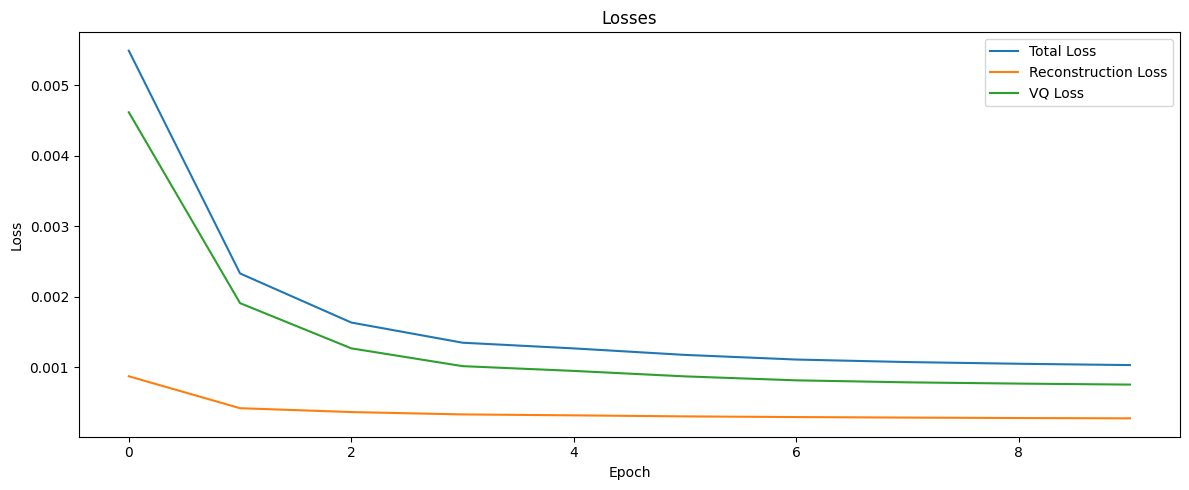

In [47]:
import os
import torch
import torch.optim as optim
import torch.nn.functional as F
from tqdm import tqdm
import matplotlib.pyplot as plt

def save_checkpoint(model, optimizer, epoch, loss_history, save_dir):
    if not os.path.exists(save_dir):
        os.makedirs(save_dir)
    
    checkpoint_path = os.path.join(save_dir, f"vqvae_epoch_{epoch}.pth")
    torch.save({
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'loss_history': loss_history
    }, checkpoint_path)

def load_checkpoint(model, optimizer, save_dir, epoch=None):
    if not os.path.exists(save_dir):
        os.makedirs(save_dir)
    if epoch is None:
        checkpoints = [f for f in os.listdir(save_dir) if f.startswith("vqvae_epoch_") and f.endswith(".pth")]
        if not checkpoints:
            print("No checkpoints found. Starting from scratch.")
            return 0, []
        
        latest_checkpoint = max(checkpoints, key=lambda x: int(x.split("_")[-1].split(".")[0]))
        checkpoint_path = os.path.join(save_dir, latest_checkpoint)
    else:
        checkpoint_path = os.path.join(save_dir, f"vqvae_epoch_{epoch}.pth")
    
    if not os.path.exists(checkpoint_path):
        print(f"No checkpoint found at {checkpoint_path}. Starting from scratch.")
        return 0, []
    
    checkpoint = torch.load(checkpoint_path)
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    epoch = checkpoint['epoch']
    loss_history = checkpoint['loss_history']
    
    print(f"Loaded checkpoint from epoch {epoch}")
    return epoch, loss_history

def train_vqvae(vqvae, dataloader, epochs=20, device="cpu", save_dir="checkpoints", resume_epoch=None):
    optimizer = optim.Adam(vqvae.parameters(), lr=1e-3)
    
    start_epoch, loss_history = load_checkpoint(vqvae, optimizer, save_dir, resume_epoch)
    
    loss_history = {'total_loss': [], 'recons_loss': [], 'vq_loss': [], 'ze_norm': [], 'zq_norm': []}
    
    for epoch in range(start_epoch, epochs):
        epoch_loss = 0
        epoch_recons_loss = 0
        epoch_vq_loss = 0
        epoch_ze_norm = 0
        epoch_zq_norm = 0

        with tqdm(enumerate(dataloader, start=1), total=len(dataloader), unit="batch") as t:
            for batch_idx, (images, _) in t:
                optimizer.zero_grad()
                images = images.to(device)
                recon_images, vq_loss, e_latent_loss, q_latent_loss = vqvae(images)
                recon_loss = F.mse_loss(recon_images, images)
                loss = recon_loss + vq_loss
                loss.backward()
                optimizer.step()
                
                epoch_loss += loss.item()
                epoch_recons_loss += recon_loss.item()
                epoch_vq_loss += vq_loss.item()
                epoch_ze_norm += e_latent_loss.item()
                epoch_zq_norm += q_latent_loss.item()
                
                t.set_description(f'Epoch [{epoch+1}/{epochs}]')
                t.set_postfix({'Train loss': f'{epoch_loss/batch_idx:.3f}', 
                               'Batch loss': f'{loss:.3f}', 
                               'Recon loss': f'{recon_loss:.3f}', 
                               'vq_loss':f'{vq_loss:.3f}'})

        epoch_size = len(dataloader.dataset)
        loss_history['total_loss'].append(epoch_loss / epoch_size)
        loss_history['recons_loss'].append(epoch_recons_loss / epoch_size)
        loss_history['vq_loss'].append(epoch_vq_loss / epoch_size)
        loss_history['ze_norm'].append(epoch_ze_norm / epoch_size)
        loss_history['zq_norm'].append(epoch_zq_norm / epoch_size)

        save_checkpoint(vqvae, optimizer, epoch + 1, loss_history, save_dir)

    return loss_history

# Usage example:
# vqvae = VQVAE(...).to(device)  # Initialize your VQVAE model
# train_loader = ...  # Your data loader

# To start or resume training:
loss_history = train_vqvae(vqvae, train_loader, epochs=10, device=device, save_dir="checkpoints")

fig, ax = plt.subplots(1, 1, figsize=(12, 5))

# Plot losses
ax.plot(loss_history['total_loss'], label='Total Loss')
ax.plot(loss_history['recons_loss'], label='Reconstruction Loss')
ax.plot(loss_history['vq_loss'], label='VQ Loss')
ax.set_xlabel('Epoch')
ax.set_ylabel('Loss')
ax.set_title('Losses')
ax.legend()

plt.tight_layout()
plt.show()



plt.show()


In [49]:
# Test function
def test_vae(model, dataloader, num_images=10, device="cpu"):
    model.eval()
    inputs, outputs = [], []
    
    with torch.no_grad():
        for batch in dataloader:
            img, _ = batch
            img = img.to(device)

            recons, _,_,_ = model(img)
            inputs.append(img.cpu())
            outputs.append(recons.cpu())
            if len(inputs) * img.size(0) >= num_images:
                break
    
    inputs = torch.cat(inputs)[:num_images]
    outputs = torch.cat(outputs)[:num_images]
    
    return inputs, outputs


def plot_reconstructions(inputs, outputs, num_images=10):
    fig, axes = plt.subplots(nrows=2, ncols=num_images, figsize=(num_images * 2.5, 5))
    
    for i in range(num_images):
        # Original image
        axes[0, i].imshow(inputs[i].squeeze(), cmap='gray', aspect='auto')
        axes[0, i].axis('off')
        axes[0, i].set_title('Original', fontsize=12, color='blue')
        
        # Reconstructed image
        axes[1, i].imshow(outputs[i].squeeze(), cmap='gray', aspect='auto')
        axes[1, i].axis('off')
        axes[1, i].set_title('Reconstructed', fontsize=12, color='green')
    
    plt.suptitle('Original vs Reconstructed Images', fontsize=16, color='darkred')
    plt.tight_layout(rect=[0, 0, 1, 0.93])  # Adjust layout to fit main title
    plt.show()

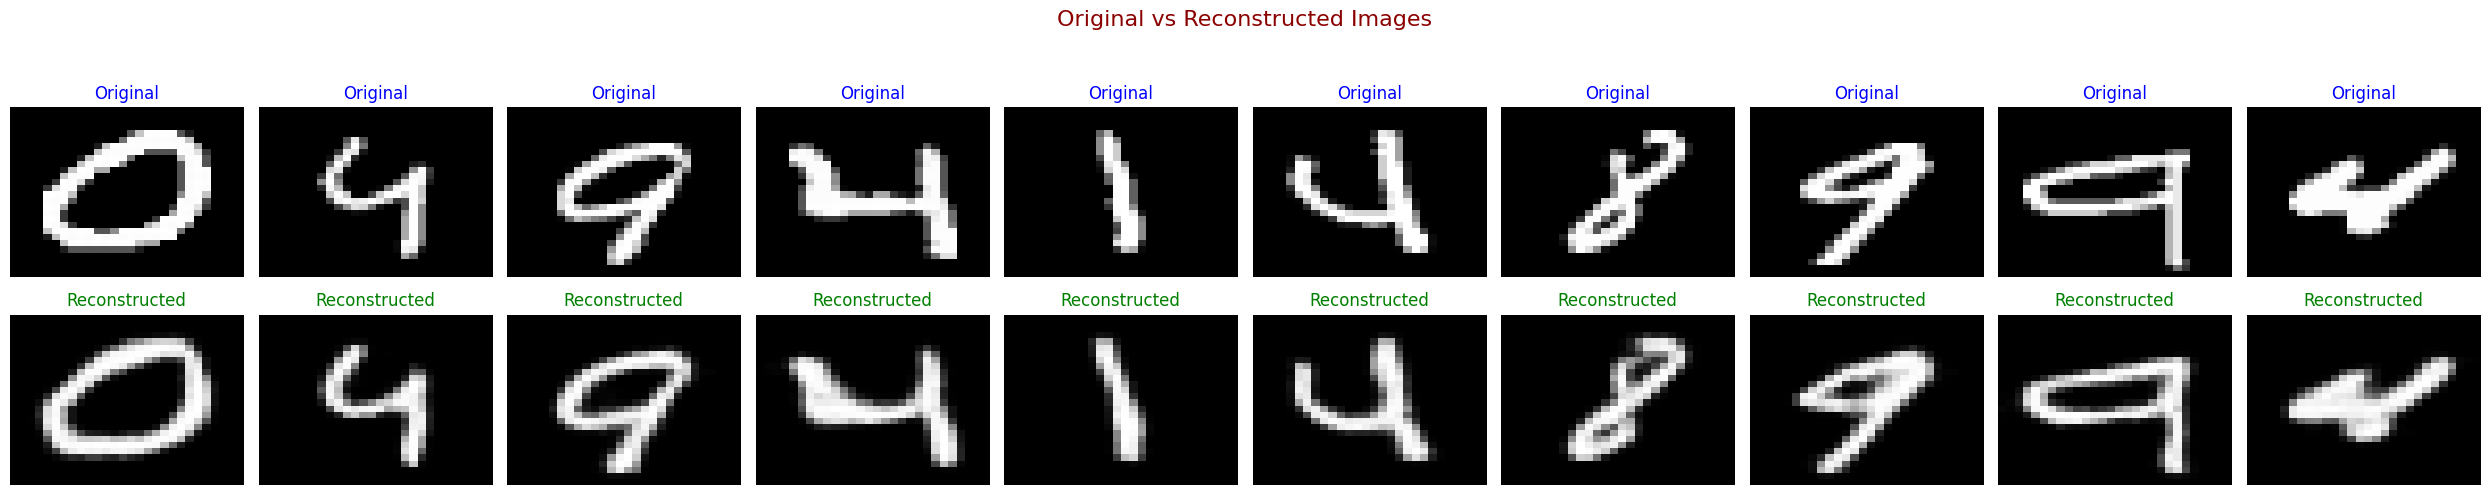

In [50]:
# Test the VAE model
inputs, outputs = test_vae(vqvae, test_loader, num_images=10, device=device)

# Plot the original and reconstructed images
plot_reconstructions(inputs, outputs, num_images=10)

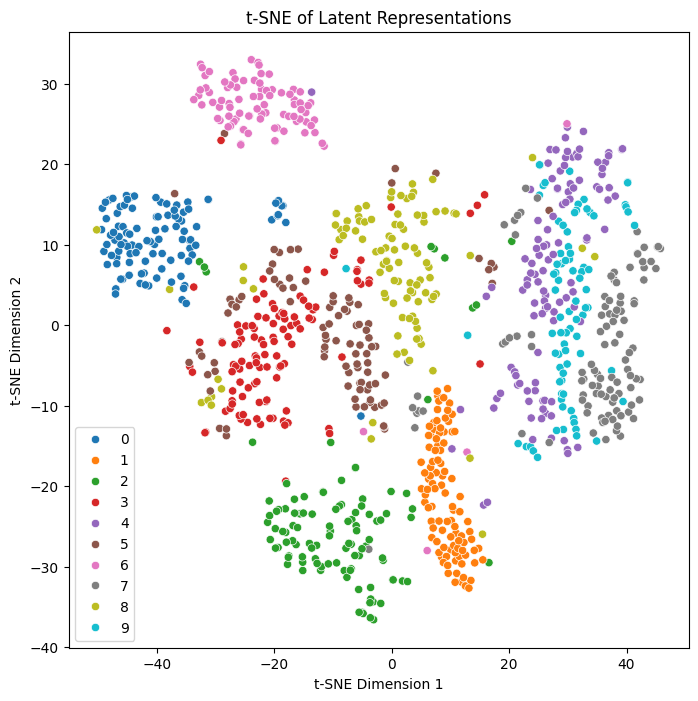

In [52]:
from sklearn.manifold import TSNE
import seaborn as sns

def visualize_latent_space(model, dataloader, device="cpu", num_samples=1000):
    model.eval()
    latent_representations = []
    labels = []
    
    with torch.no_grad():
        for batch in dataloader:
            images, lbls = batch
            images = images.to(device)
            z = model.encoder(images)
            latent_representations.append(z.view(z.size(0), -1).cpu().numpy())
            labels.append(lbls.cpu().numpy())
            if len(latent_representations) * images.size(0) >= num_samples:
                break
    
    latent_representations = np.concatenate(latent_representations)[:num_samples]
    labels = np.concatenate(labels)[:num_samples]
    
    # Reduce dimensions with t-SNE
    tsne = TSNE(n_components=2, random_state=42)
    tsne_results = tsne.fit_transform(latent_representations)
    
    # Plot the t-SNE results
    plt.figure(figsize=(8, 8))
    sns.scatterplot(x=tsne_results[:, 0], y=tsne_results[:, 1], hue=labels, palette="tab10", legend="full")
    plt.title('t-SNE of Latent Representations')
    plt.xlabel('t-SNE Dimension 1')
    plt.ylabel('t-SNE Dimension 2')
    plt.show()

# Visualize the latent space using t-SNE
visualize_latent_space(vqvae, test_loader, device=device, num_samples=1000)
